In [2]:
import environ

env = environ.Env()
environ.Env.read_env()
#Todo only load the repo folder
DataSetsPath     = env('DataSetsPath')     #* get the path of the script
ModelsPath       = env('ModelsPath')       #* get the path of the script
FitFunctionsPath = env('FitFunctionsPath') #* get the path of the script
root_Data        = env('DataSet_Dogs_Vs_catsPath')         #* get the path of the dataSet of the fist 12_000 img of https://www.kaggle.com/c/dogs-vs-cats
root_Data_Val    = env('DataSet_Dogs_Vs_catsValPath')      #* get the path of the dataSet of the last 500 img of https://www.kaggle.com/c/dogs-vs-cats
model_save_dir   = env('model_save_dir')   #* get the path where we will save the model


import sys
sys.path.append(DataSetsPath)
sys.path.append(ModelsPath)
sys.path.append(FitFunctionsPath)


import torch
import torchvision.transforms as transforms
from DataSets.dataSet_CatsVsDogs import DataSet_Img_To_Label
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
image_Height   = 300
image_Width    = 300
image_Channels = 3
batch_size     = 128


In [3]:

from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, RandomSampler


data_augmentation = transforms.Compose([
                        #* Compose = compoues a list of function
                        transforms.ToPILImage(),
                        transforms.Resize((image_Height, image_Width)),
                        transforms.RandomRotation(degrees=5),  # Randomly rotate the image by up to 5 degrees
                                        
                        #* ToPILImage = cahnge the data type from PyTorch tensor or a NumPy ndarray to : A PIL (Python Imaging Library)
                        # transforms.RandomVerticalFlip(),
                        # transforms.RandomHorizontalFlip(),
                        # transforms.RandomRotation(degrees=15),  
                        transforms.ToTensor(), 
                        #* change the data type from Numpy or PIL to tensor
                        ])


myDataSet     = DataSet_Img_To_Label(root_Data,     data_augmentation, test = False, dataSize = 1000)
myDataSetVal  = DataSet_Img_To_Label(root_Data_Val, data_augmentation, test = False, dataSize = 100) 
#TODO make the validation dataSet

print("myDataSet     = ", myDataSet)
print("myDataSetVal = ", myDataSetVal)
my_Data_Loader      = DataLoader(myDataSet  , batch_size = batch_size, num_workers = 0,  shuffle = True) # sampler = random_sampler = RandomSampler(myDataSet) 
my_Data_Loader_Val = DataLoader(myDataSetVal, batch_size = batch_size, num_workers = 0,  shuffle = True)


myDataSet     =  len(dataSet) =  24000
dataSet[0]   =  ('cat.0.jpg', 1)

myDataSetVal =  len(dataSet) =  1000
dataSet[0]   =  ('cat.12000.jpg', 1)



In [4]:
import matplotlib.pyplot as plt
import numpy as np
from Models.models_CatsVsDogs import modelCNN
from Models.models_CatsVsDogs import modelSiLU


# myModel = Cnn()
# myModel = modelCNN()
myModel = modelSiLU(HEIGHT = image_Height, WIDTH = image_Width, CHANNELS = image_Channels)
myModel.to(device = device)



# print(myModel.state_dict().keys())
# weights = myModel.state_dict()['conv_1.weight']

# # Get the number of filters and channels
# num_filters = weights.shape[0]
# num_channels = weights.shape[1]

# # Create subplots for each filter
# fig, axs = plt.subplots(num_filters, num_channels, figsize=(10, 10))

# # Plot each filter
# for i in range(num_filters):
#     for j in range(num_channels):
#         axs[i, j].imshow(weights[i, j].cpu().detach().numpy(), cmap='viridis')
#         axs[i, j].axis('off')

# plt.tight_layout()
# plt.show()



modelSiLU(
  (Sect_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Sect_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Sect_3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flat_1): Linear(in_features=1600, out_features=10, bias=True)
  (SiLU): SiLU()
  (dens_1): Sequential(
    (0):

In [5]:

#* test train_modelCNN
from FitFunctions.fitFunctionsForCatsVsDogs import train_modelCNN
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


opt_model = optim.Adam(myModel.parameters(), lr = 0.001)
# criterion = nn.BCELoss()
# criterion = torch.nn.MSELoss()
criterion = nn.CrossEntropyLoss()

history = train_modelCNN(my_Data_Loader, 
                        myModel, 
                        opt_model, 
                        device      = device, 
                        num_epochs  = 30, 
                        get_History = True, 
                        criterion   = criterion, 
                        getValLoos  = True, 
                        data_loader_Val = my_Data_Loader_Val,
                        model_save_dir  = model_save_dir)
# print(myModel.state_dict().keys())
# weights = myModel.state_dict()['dens_1.4.weight']



  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1/30 process: 99: 100%|██████████| 188/188 [02:19<00:00,  1.35it/s, modelLoss=0.573]


Epoch completed, Average Loss: 0.5802
Epoch completed, Average Val Loss: 0.5531


Epoch 2/30 process: 99: 100%|██████████| 188/188 [01:38<00:00,  1.91it/s, modelLoss=0.543]


Epoch completed, Average Loss: 0.5016
Epoch completed, Average Val Loss: 0.5304


Epoch 3/30 process: 99: 100%|██████████| 188/188 [01:02<00:00,  3.01it/s, modelLoss=0.382]


Epoch completed, Average Loss: 0.4476
Epoch completed, Average Val Loss: 0.4185


Epoch 4/30 process: 99: 100%|██████████| 188/188 [01:04<00:00,  2.93it/s, modelLoss=0.41] 


Epoch completed, Average Loss: 0.4054
Epoch completed, Average Val Loss: 0.4161


Epoch 5/30 process: 99: 100%|██████████| 188/188 [01:03<00:00,  2.95it/s, modelLoss=0.478]


Epoch completed, Average Loss: 0.3751
Epoch completed, Average Val Loss: 0.3760


Epoch 6/30 process: 99: 100%|██████████| 188/188 [01:03<00:00,  2.97it/s, modelLoss=0.373]


Epoch completed, Average Loss: 0.3546
Epoch completed, Average Val Loss: 0.3762


Epoch 7/30 process: 99: 100%|██████████| 188/188 [01:02<00:00,  3.00it/s, modelLoss=0.303]


Epoch completed, Average Loss: 0.3293
Epoch completed, Average Val Loss: 0.3887


Epoch 8/30 process: 99: 100%|██████████| 188/188 [01:02<00:00,  3.01it/s, modelLoss=0.258]


Epoch completed, Average Loss: 0.3121
Epoch completed, Average Val Loss: 0.3683


Epoch 9/30 process: 99: 100%|██████████| 188/188 [01:02<00:00,  3.02it/s, modelLoss=0.456]


Epoch completed, Average Loss: 0.2962
Epoch completed, Average Val Loss: 0.3464


Epoch 10/30 process: 99: 100%|██████████| 188/188 [01:02<00:00,  3.01it/s, modelLoss=0.235]


Epoch completed, Average Loss: 0.2769
Epoch completed, Average Val Loss: 0.3419


Epoch 11/30 process: 99: 100%|██████████| 188/188 [01:00<00:00,  3.10it/s, modelLoss=0.339]


Epoch completed, Average Loss: 0.2690
Epoch completed, Average Val Loss: 0.3499


Epoch 12/30 process: 99: 100%|██████████| 188/188 [01:02<00:00,  3.03it/s, modelLoss=0.237]


Epoch completed, Average Loss: 0.2616
Epoch completed, Average Val Loss: 0.3352


Epoch 13/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.37] 


Epoch completed, Average Loss: 0.2466
Epoch completed, Average Val Loss: 0.3334


Epoch 14/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.06it/s, modelLoss=0.263]


Epoch completed, Average Loss: 0.2307
Epoch completed, Average Val Loss: 0.3630


Epoch 15/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.07it/s, modelLoss=0.273]


Epoch completed, Average Loss: 0.2259
Epoch completed, Average Val Loss: 0.3877


Epoch 16/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.04it/s, modelLoss=0.217]


Epoch completed, Average Loss: 0.2172
Epoch completed, Average Val Loss: 0.3300


Epoch 17/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.151]


Epoch completed, Average Loss: 0.2044
Epoch completed, Average Val Loss: 0.3189


Epoch 18/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.06it/s, modelLoss=0.245]


Epoch completed, Average Loss: 0.1985
Epoch completed, Average Val Loss: 0.3564


Epoch 19/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.255]


Epoch completed, Average Loss: 0.1932
Epoch completed, Average Val Loss: 0.3399


Epoch 20/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.268]


Epoch completed, Average Loss: 0.1871
Epoch completed, Average Val Loss: 0.3319


Epoch 21/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.175]


Epoch completed, Average Loss: 0.1758
Epoch completed, Average Val Loss: 0.3605


Epoch 22/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.0936]


Epoch completed, Average Loss: 0.1695
Epoch completed, Average Val Loss: 0.3391


Epoch 23/30 process: 99: 100%|██████████| 188/188 [01:02<00:00,  3.03it/s, modelLoss=0.227] 


Epoch completed, Average Loss: 0.1670
Epoch completed, Average Val Loss: 0.3432


Epoch 24/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.06it/s, modelLoss=0.145] 


Epoch completed, Average Loss: 0.1560
Epoch completed, Average Val Loss: 0.3504


Epoch 25/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.127] 


Epoch completed, Average Loss: 0.1499
Epoch completed, Average Val Loss: 0.3822


Epoch 26/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.325] 


Epoch completed, Average Loss: 0.1587
Epoch completed, Average Val Loss: 0.3548


Epoch 27/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.197] 


Epoch completed, Average Loss: 0.1473
Epoch completed, Average Val Loss: 0.4554


Epoch 28/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.06it/s, modelLoss=0.164] 


Epoch completed, Average Loss: 0.1371
Epoch completed, Average Val Loss: 0.4441


Epoch 29/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.073] 


Epoch completed, Average Loss: 0.1304
Epoch completed, Average Val Loss: 0.3793


Epoch 30/30 process: 99: 100%|██████████| 188/188 [01:01<00:00,  3.05it/s, modelLoss=0.0587]


Epoch completed, Average Loss: 0.1419
Epoch completed, Average Val Loss: 0.4432


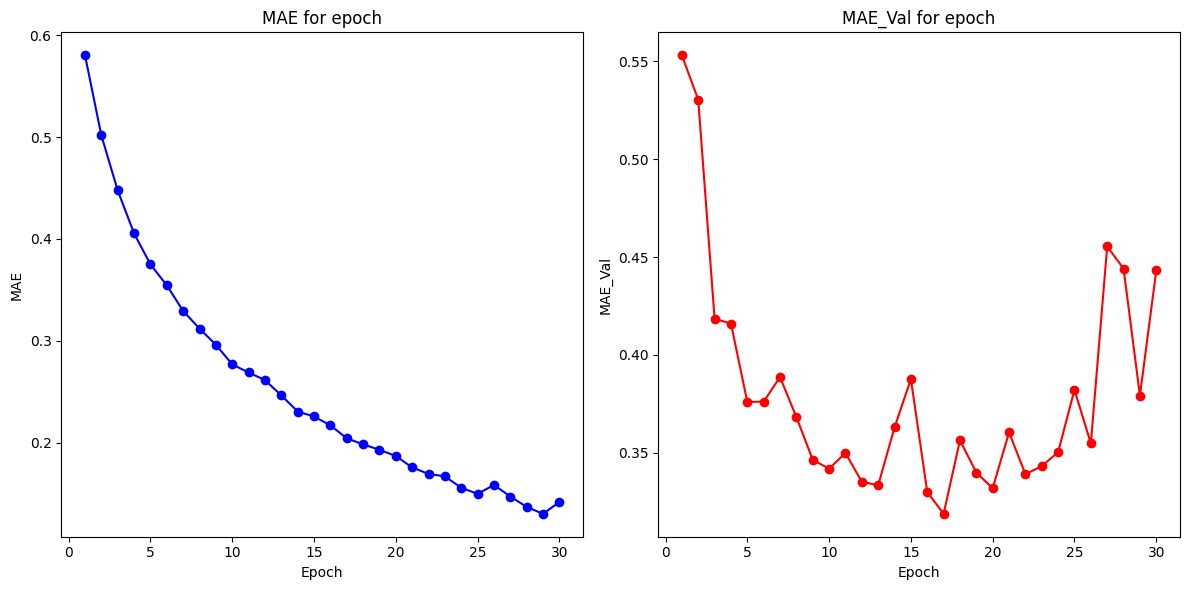

In [6]:
import matplotlib.pyplot as plt

Epochs_values     = range(1, len(history['MAE']) + 1)
Epochs_values_Val = range(1, len(history['MAE_Val']) + 1)

# Create two subplots (one for MAE and one for MAE_Val) in a single row
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot MAE in the first subplot
plt1.plot(Epochs_values, history['MAE'], marker='o', color='blue')
plt1.set_xlabel('Epoch')
plt1.set_ylabel('MAE')
plt1.set_title('MAE for epoch')

# Plot MAE_Val in the second subplot
plt2.plot(Epochs_values_Val, history['MAE_Val'], marker='o', color='red')
plt2.set_xlabel('Epoch')
plt2.set_ylabel('MAE_Val')
plt2.set_title('MAE_Val for epoch')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


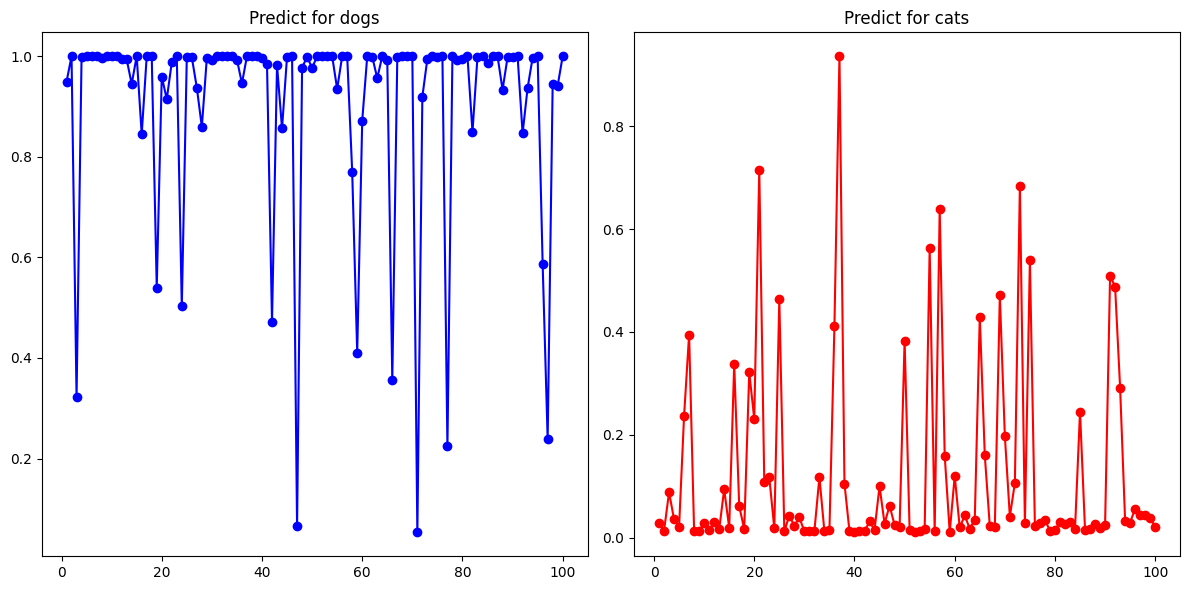

In [7]:
import numpy as np
import os
from PIL import Image

img_pth = root_Data + '/'

dog_paths = ['dog.' + str(i) + '.jpg' for i in range(0, 100)]
cat_paths = ['cat.' + str(i) + '.jpg' for i in range(0, 100)]

def getArrayBatch(paths):

    tensor_batch = []
    for path in paths:
        img  = os.path.join(img_pth + path)
        img  = np.array(Image.open(img))
        img  = img [:, :, :3]
        img = data_augmentation(img)
        tensor_batch.append(img)

    tensor_batch = torch.stack(tensor_batch).cuda()
    tensor_batch = myModel(tensor_batch)
    tensor_batch = torch.softmax(tensor_batch, dim=1)[:, 0].cpu().detach().numpy()  # Extract probability for the positive class
    # tensor_batch = tensor_batch.cpu().detach().numpy()
    return tensor_batch

predict_Array_dogs = getArrayBatch(dog_paths)
predict_Array_cats = getArrayBatch(cat_paths)

import matplotlib.pyplot as plt

num_images_dogs     = range(1, len(predict_Array_dogs) + 1)
num_images_cats = range(1, len(predict_Array_dogs) + 1)

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(12, 6))

plt1.plot(num_images_dogs, predict_Array_dogs, marker='o', color='blue')
plt1.set_title('Predict for dogs')
plt2.plot(num_images_cats, predict_Array_cats, marker='o', color='red')
plt2.set_title('Predict for cats')

plt.tight_layout()
plt.show()



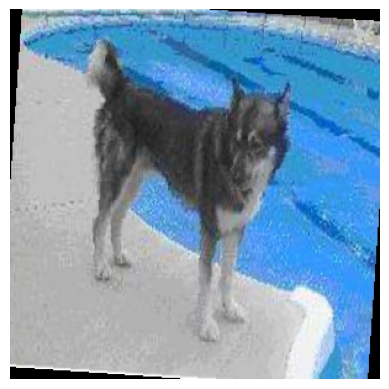

array([0.57990026], dtype=float32)

In [8]:
# TODO use the model 
import os 
from PIL import Image

img_pth = root_Data_Val + '/dog.12403.jpg' 

img  = os.path.join(img_pth)
img  = np.array(Image.open(img))
img  = img [:, :, :3]
img  = data_augmentation(img)


img_array = img.permute(1, 2, 0).numpy()  # Assuming the tensor is of shape [3, height, width]
# Plot the image
img = img.unsqueeze(0)
plt.imshow(img_array)
plt.axis('off')  # Turn off axis
plt.show()

torch.softmax(myModel(img.cuda()), dim=1)[:, 0].cpu().detach().numpy()
